In [1]:
import tensorflow as tf
import numpy as np

from skimage import io, transform
from tqdm import trange
from scipy import misc
from glob import glob

from PIL.Image import fromarray
from io import BytesIO
from IPython.display import display, Image

In [2]:
def imshow(img):
    img = (img * 255).astype('uint8')
    buf = BytesIO()
    fromarray(img, 'RGB').save(buf, 'png')
    display(Image(buf.getvalue()))
    
def imsave(filename, img):
    misc.imsave(filename, (img * 255).astype('uint8'))

In [3]:
faces = glob('img_align_celeba/*.jpg')
faces = np.asarray([transform.resize(io.imread(fname), (64, 64)) for fname in faces])

In [4]:
def generator(z):
    with tf.variable_scope('Generator') as scope:
        if scope.trainable_variables():
            scope.reuse_variables()

        x = tf.contrib.layers.fully_connected(z, 4*4*1024, activation_fn=None)
        x = tf.reshape(x, [-1, 4, 4, 1024])
        x = tf.contrib.layers.conv2d_transpose(x, 512, 5, 2)
        x = tf.contrib.layers.conv2d_transpose(x, 256, 5, 2)
        x = tf.contrib.layers.conv2d_transpose(x, 128, 5, 2)
        x = tf.contrib.layers.conv2d_transpose(x, 3, 5, 2, activation_fn=tf.nn.sigmoid)

    return x

def generator_vars():
    with tf.variable_scope('Generator') as scope:
        return scope.trainable_variables()

In [5]:
def leaky_relu(x, a=.2):
    return tf.maximum(x, a * x)

def discriminator(x):
    with tf.variable_scope('Discriminator') as scope:
        if scope.trainable_variables():
            scope.reuse_variables()
            
        y = tf.contrib.layers.conv2d(x, 128, 5, 2, activation_fn=leaky_relu)
        y = tf.contrib.layers.conv2d(y, 256, 5, 2, activation_fn=leaky_relu)
        y = tf.contrib.layers.conv2d(y, 512, 5, 2, activation_fn=leaky_relu)
        y = tf.contrib.layers.conv2d(y, 1024, 5, 2, activation_fn=leaky_relu)
        y = tf.contrib.layers.fully_connected(y, 1, activation_fn=None)
            
    return y

def discriminator_vars():
    with tf.variable_scope('Discriminator') as scope:
        return scope.trainable_variables()

In [6]:
tf.reset_default_graph()

z = tf.placeholder(tf.float32, (None, 100), name='z')
x = tf.placeholder(tf.float32, (None, 64, 64, 3), name='x')
e = tf.placeholder(tf.float32, (None, 1, 1, 1), name='e')

x_tilde = generator(z)
x_hat = e * x + (1 - e) * x_tilde

gradients = tf.gradients(discriminator(x_hat), [x_hat])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
penalty = 10 * tf.reduce_mean((slopes - 1) ** 2)

dloss = tf.reduce_mean(discriminator(x_tilde) - discriminator(x) + penalty)
gloss = tf.reduce_mean(-discriminator(generator(z)))

summary = tf.summary.merge([
    tf.summary.scalar('Disc_Loss', dloss),
    tf.summary.scalar('Gen_Loss', gloss),
])

dtrain = tf.train.AdamOptimizer(.0001, 0, .9).minimize(dloss, var_list=discriminator_vars())
gtrain = tf.train.AdamOptimizer(.0001, 0, .9).minimize(gloss, var_list=generator_vars())

In [7]:
num_epochs = 25
batch_size = 100
data_size = len(faces)
num_steps = num_epochs * data_size // batch_size
output_interval = 100
save_interval = 500

def gen_input(n=batch_size):
    return {
        z: np.random.random((n, 100)),
        x: faces[np.random.choice(data_size, n)],
        e: np.random.random((n, 1, 1, 1))
    }

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('logs', sess.graph)
    saver = tf.train.Saver()

    def output(step, save=True):
        prefix = str(step).rjust(5, '0')
        imgs = sess.run(generator(z), gen_input(5))
        for i, img in enumerate(imgs):
            imsave('output/{}-{}-rand.png'.format(prefix, i), img)
            
    def save():
        saver.save(sess, 'model/model.ckpt')

    for step in trange(num_steps):
        for t in range(5):
            sess.run(dtrain, gen_input())
        sess.run(gtrain, gen_input())

        ss = sess.run(summary, gen_input())
        writer.add_summary(ss, step)
        writer.flush()

        if step % output_interval == 0:
            output(step)
        if step % save_interval == 0:
            save()

    output('result')
    save()
    writer.close()

100%|██████████| 50649/50649 [27:42:55<00:00,  1.97s/it]   


In [40]:
def interpolate_z(n=10, m=10):
    zs = []
    for _ in range(n):
        z0, z1 = np.random.random(100), np.random.random(100)
        z = [z0*e + z1*(1-e) for e in np.arange(m)/(m-1)]
        zs.extend(z)
    return np.asarray(zs)

INFO:tensorflow:Restoring parameters from model/model.ckpt


INFO:tensorflow:Restoring parameters from model/model.ckpt


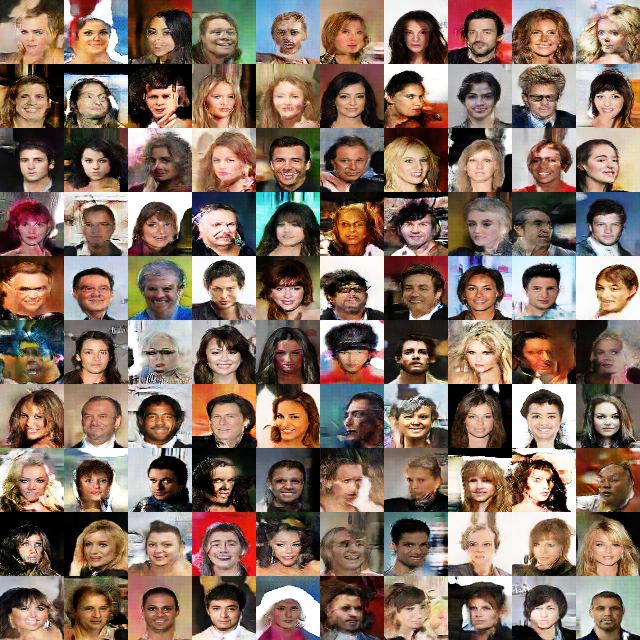

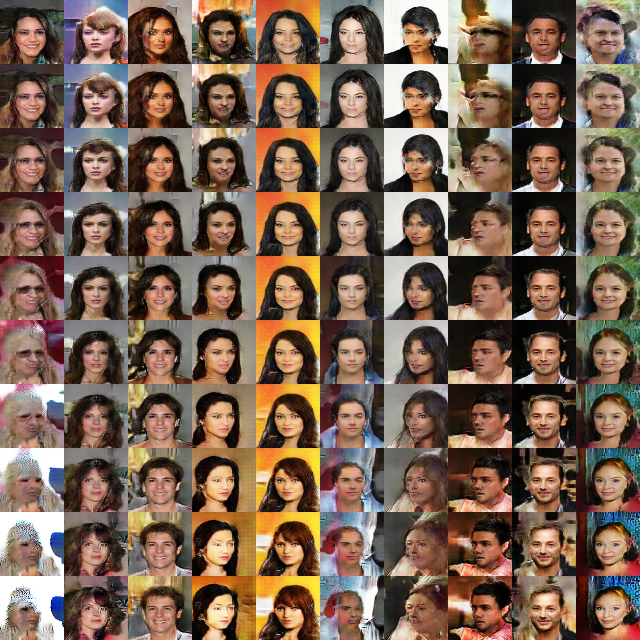

In [44]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, 'model/model.ckpt')
    
    y = sess.run(generator(z), {z: np.random.random((100, 100))})
    y = np.hstack(np.array_split(np.concatenate(y), 10))
    imshow(y)
    
    y = sess.run(generator(z), {z: interpolate_z(10, 10)})
    y = np.hstack(np.array_split(np.concatenate(y), 10))
    imshow(y)
    
    